# aiaprep Sandbox

In [186]:
import copy
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.time
import drms
from sunpy.map import Map
from sunpy.util import MetaDict
from sunpy.instr.aia import aiaprep
import hissw

%matplotlib inline

In [44]:
m = Map('/Users/barnes/sunpy/data/aia.lev1_euv_12s.2011-02-11T235937Z.171.image_lev1.fits')

In [136]:
m = Map(np.where(m.data<=0,1,m.data),m.meta)

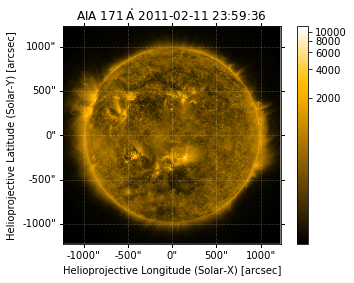

In [137]:
m.peek()

In [138]:
def aiaprep_wrapper(aiamap, use_3h_pointing=True):
    if use_3h_pointing:
        w = aiamap.wavelength.to(u.angstrom).value
        # Get 3h pointing data for the last day
        q = drms.Client().query(
            f'aia.master_pointing3h[{aiamap.date.isot}/1d]',
            key=f'T_START , A_{w:03.0f}_X0 , A_{w:03.0f}_Y0 , A_{w:03.0f}_INSTROT , A_{w:03.0f}_IMSCALE')
        # Select entry closest to obstime of map
        delta_t = ((q['T_START'].apply(astropy.time.Time) - aiamap.date)
           .apply(astropy.time.TimeDelta.to, args=('s',))
           .apply(u.Quantity.to_value)
           .apply(abs))
        pointing = q.iloc[delta_t.index[delta_t==delta_t.min()]]
        # Update header
        new_meta = copy.deepcopy(aiamap.meta)
        new_meta['CRPIX1'] = pointing[f'A_{w:03.0f}_X0'][0]
        new_meta['CRPIX2'] = pointing[f'A_{w:03.0f}_Y0'][0]
        new_meta['CDELT1'] = pointing[f'A_{w:03.0f}_IMSCALE'][0]
        new_meta['CDELT2'] = pointing[f'A_{w:03.0f}_IMSCALE'][0]
        new_meta['CROTA2'] = pointing[f'A_{w:03.0f}_INSTROT'][0]
        aiamap = Map(aiamap.data, new_meta)
    
    return aiaprep(aiamap)

In [229]:
%%timeit -n 1 -r 1
m_prep_sunpy_3h = aiaprep_wrapper(m, use_3h_pointing=False)

4.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [140]:
m_prep_sunpy = aiaprep_wrapper(m, use_3h_pointing=False)

Compare to version in SSW

In [141]:
ssw = hissw.ScriptMaker(ssw_packages=['sdo/aia','vobs/ontology'],ssw_paths=['aia','ontology'])

First, use most accurate pointing available

In [142]:
script = """
aia_prep,{{filenames}},{{indices}},oindex,odata
"""

In [143]:
input_args = {
    'filenames': ['/Users/barnes/sunpy/data/aia.lev1_euv_12s.2011-02-11T235937Z.171.image_lev1.fits'],
    'indices': [0]
}
save_vars = ['oindex','odata']

In [144]:
res = ssw.run(script,args=input_args,save_vars=save_vars,verbose=False)

In [145]:
meta = MetaDict({k:(res['oindex'][k][0]).decode('utf-8') if type(res['oindex'][k][0]) is bytes
                 else res['oindex'][k][0] for k in res['oindex'].dtype.names})

In [146]:
m_prep_ssw = Map(res['odata'],meta)

In [156]:
m_prep_ssw = Map(np.where(m_prep_ssw.data<=0,1,m_prep_ssw.data),m_prep_ssw.meta)

Then, use pointing information straight from the header

In [147]:
script = """
aia_prep,{{filenames}},{{indices}},oindex,odata,/use_hdr_pnt
"""

In [148]:
res = ssw.run(script,args=input_args,save_vars=save_vars,verbose=False)

In [149]:
meta = MetaDict({k:(res['oindex'][k][0]).decode('utf-8') if type(res['oindex'][k][0]) is bytes
                 else res['oindex'][k][0] for k in res['oindex'].dtype.names})

In [150]:
m_prep_ssw_hdr_pnt = Map(res['odata'],meta)

Now compare all of the different results

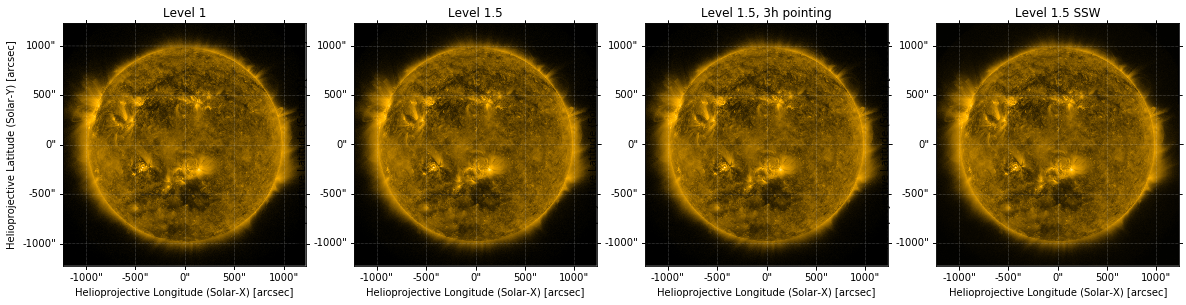

In [151]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(141,projection=m)
m.plot(axes=ax,title='Level 1')
ax = fig.add_subplot(142,projection=m_prep_sunpy)
m_prep_sunpy.plot(axes=ax,title='Level 1.5')
ax = fig.add_subplot(143,projection=m_prep_sunpy_3h)
m_prep_sunpy_3h.plot(axes=ax,title='Level 1.5, 3h pointing')
ax = fig.add_subplot(144,projection=m_prep_ssw)
m_prep_ssw.plot(axes=ax,title='Level 1.5 SSW')

/Users/barnes/anaconda3/envs/aiapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


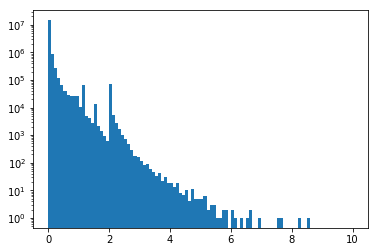

In [152]:
plt.hist((np.fabs((m_prep_ssw.data - m_prep_sunpy.data)/m_prep_ssw.data)).flatten(),bins=100,range=[0,10],log=True);

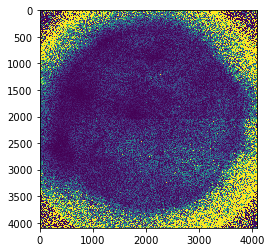

In [158]:
plt.subplot(111)
plt.imshow(np.fabs(m_prep_sunpy.data - m_prep_ssw.data)/m_prep_ssw.data,vmin=0,vmax=0.1)

/Users/barnes/anaconda3/envs/aiapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


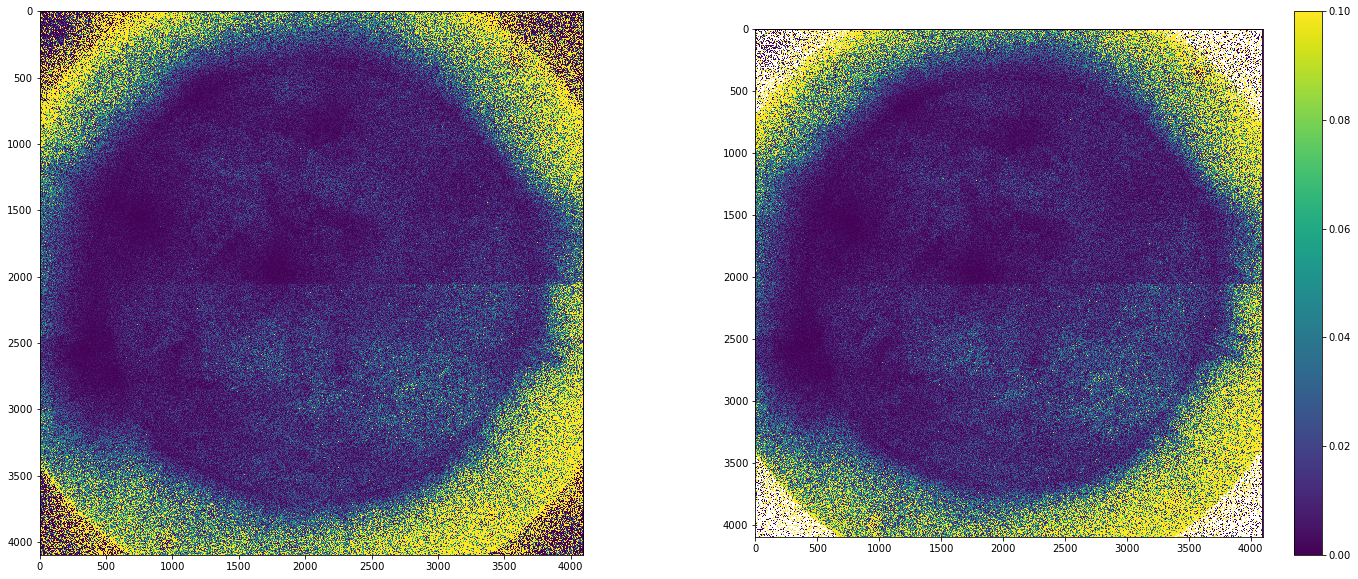

In [157]:
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(np.fabs(m_prep_sunpy.data - m_prep_ssw.data)/m_prep_ssw.data,vmin=0,vmax=0.1)#norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e2))
#plt.colorbar()
plt.subplot(122)
plt.imshow(np.fabs(m_prep_sunpy.data - m_prep_ssw_hdr_pnt.data)/m_prep_ssw_hdr_pnt.data,vmin=0,vmax=0.1)#norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e2))
plt.colorbar()

/Users/barnes/anaconda3/envs/aiapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/barnes/anaconda3/envs/aiapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


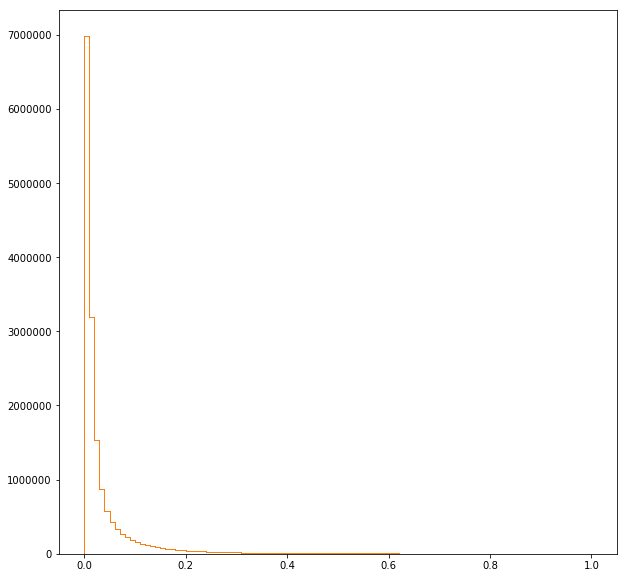

In [92]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
d = np.fabs((m_prep_sunpy.data - m_prep_ssw.data)/m_prep_ssw.data).flatten()
ax.hist(d,bins=100,range=[0,1],histtype='step');
d = np.fabs((m_prep_sunpy.data - m_prep_ssw_3h.data)/m_prep_ssw_3h.data).flatten()
ax.hist(d,bins=100,range=[0,1],histtype='step');

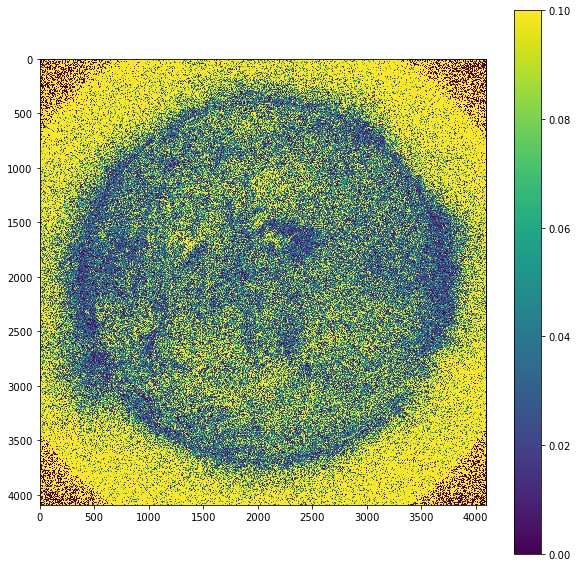

In [134]:
plt.figure(figsize=(10,10))
plt.imshow(np.fabs(m_prep_sunpy.data - m_prep_sunpy_3h.data)/m_prep_sunpy.data,vmin=0,vmax=.1)#norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e2))
plt.colorbar()

In [10]:
d = np.fabs(m_prep.data - m_prep_old.data)

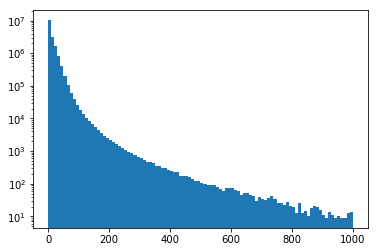

In [11]:
plt.hist(d.flatten(),bins=100,range=[0,1e3],log=True);

In [262]:
y_indices,x_indices = np.indices(m.data.shape)
img_coords = m.pixel_to_world(y_indices*u.pixel,x_indices*u.pixel)
rsun_obs = ((const.R_sun / (m.observer_coordinate.radius - const.R_sun)).decompose()* u.radian).to(u.arcsec)
img_r = np.sqrt(img_coords.Tx**2 + img_coords.Ty**2)
m_ones = Map((img_r < rsun_obs).astype(float),m.meta)

In [247]:
m_ones.save('/Users/barnes/Desktop/ones_prep_test.fits',overwrite=True)

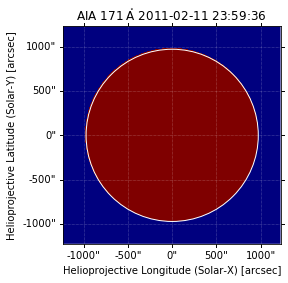

In [248]:
m_ones.plot(cmap='jet')
m_ones.draw_limb()

In [249]:
m_ones_prep_sunpy = aiaprep_wrapper(m_ones,use_3h_pointing=False)

In [250]:
script = """
aia_prep,{{filenames}},{{indices}},oindex,odata,/use_hdr_pnt
"""

In [251]:
input_args = {
    'filenames': ['/Users/barnes/Desktop/ones_prep_test.fits'],
    'indices': [0]
}
save_vars = ['oindex','odata']

In [252]:
res = ssw.run(script,args=input_args,save_vars=save_vars,verbose=False)

In [253]:
meta = MetaDict({k:(res['oindex'][k][0]).decode('utf-8') if type(res['oindex'][k][0]) is bytes
                 else res['oindex'][k][0] for k in res['oindex'].dtype.names})

In [254]:
m_ones_prep_ssw = Map(res['odata'],meta)

In [255]:
m_prep_diff = (m_ones_prep_ssw.data - m_ones_prep_sunpy.data)

In [264]:
img_r / rsun_obs

<Quantity [[1.77853522, 1.77810252, 1.77766992, ..., 1.7820354 ,
            1.78246907, 1.78290284],
           [1.77809991, 1.7776671 , 1.7772344 , ..., 1.78160094,
            1.78203471, 1.78246859],
           [1.7776647 , 1.77723179, 1.77679898, ..., 1.78116659,
            1.78160047, 1.78203445],
           ...,
           [1.77134873, 1.77091427, 1.77047992, ..., 1.77486308,
            1.77529851, 1.77573403],
           [1.7717824 , 1.77134805, 1.7709138 , ..., 1.77529589,
            1.77573121, 1.77616663],
           [1.77221617, 1.77178192, 1.77134778, ..., 1.77572881,
            1.77616401, 1.77659933]]>

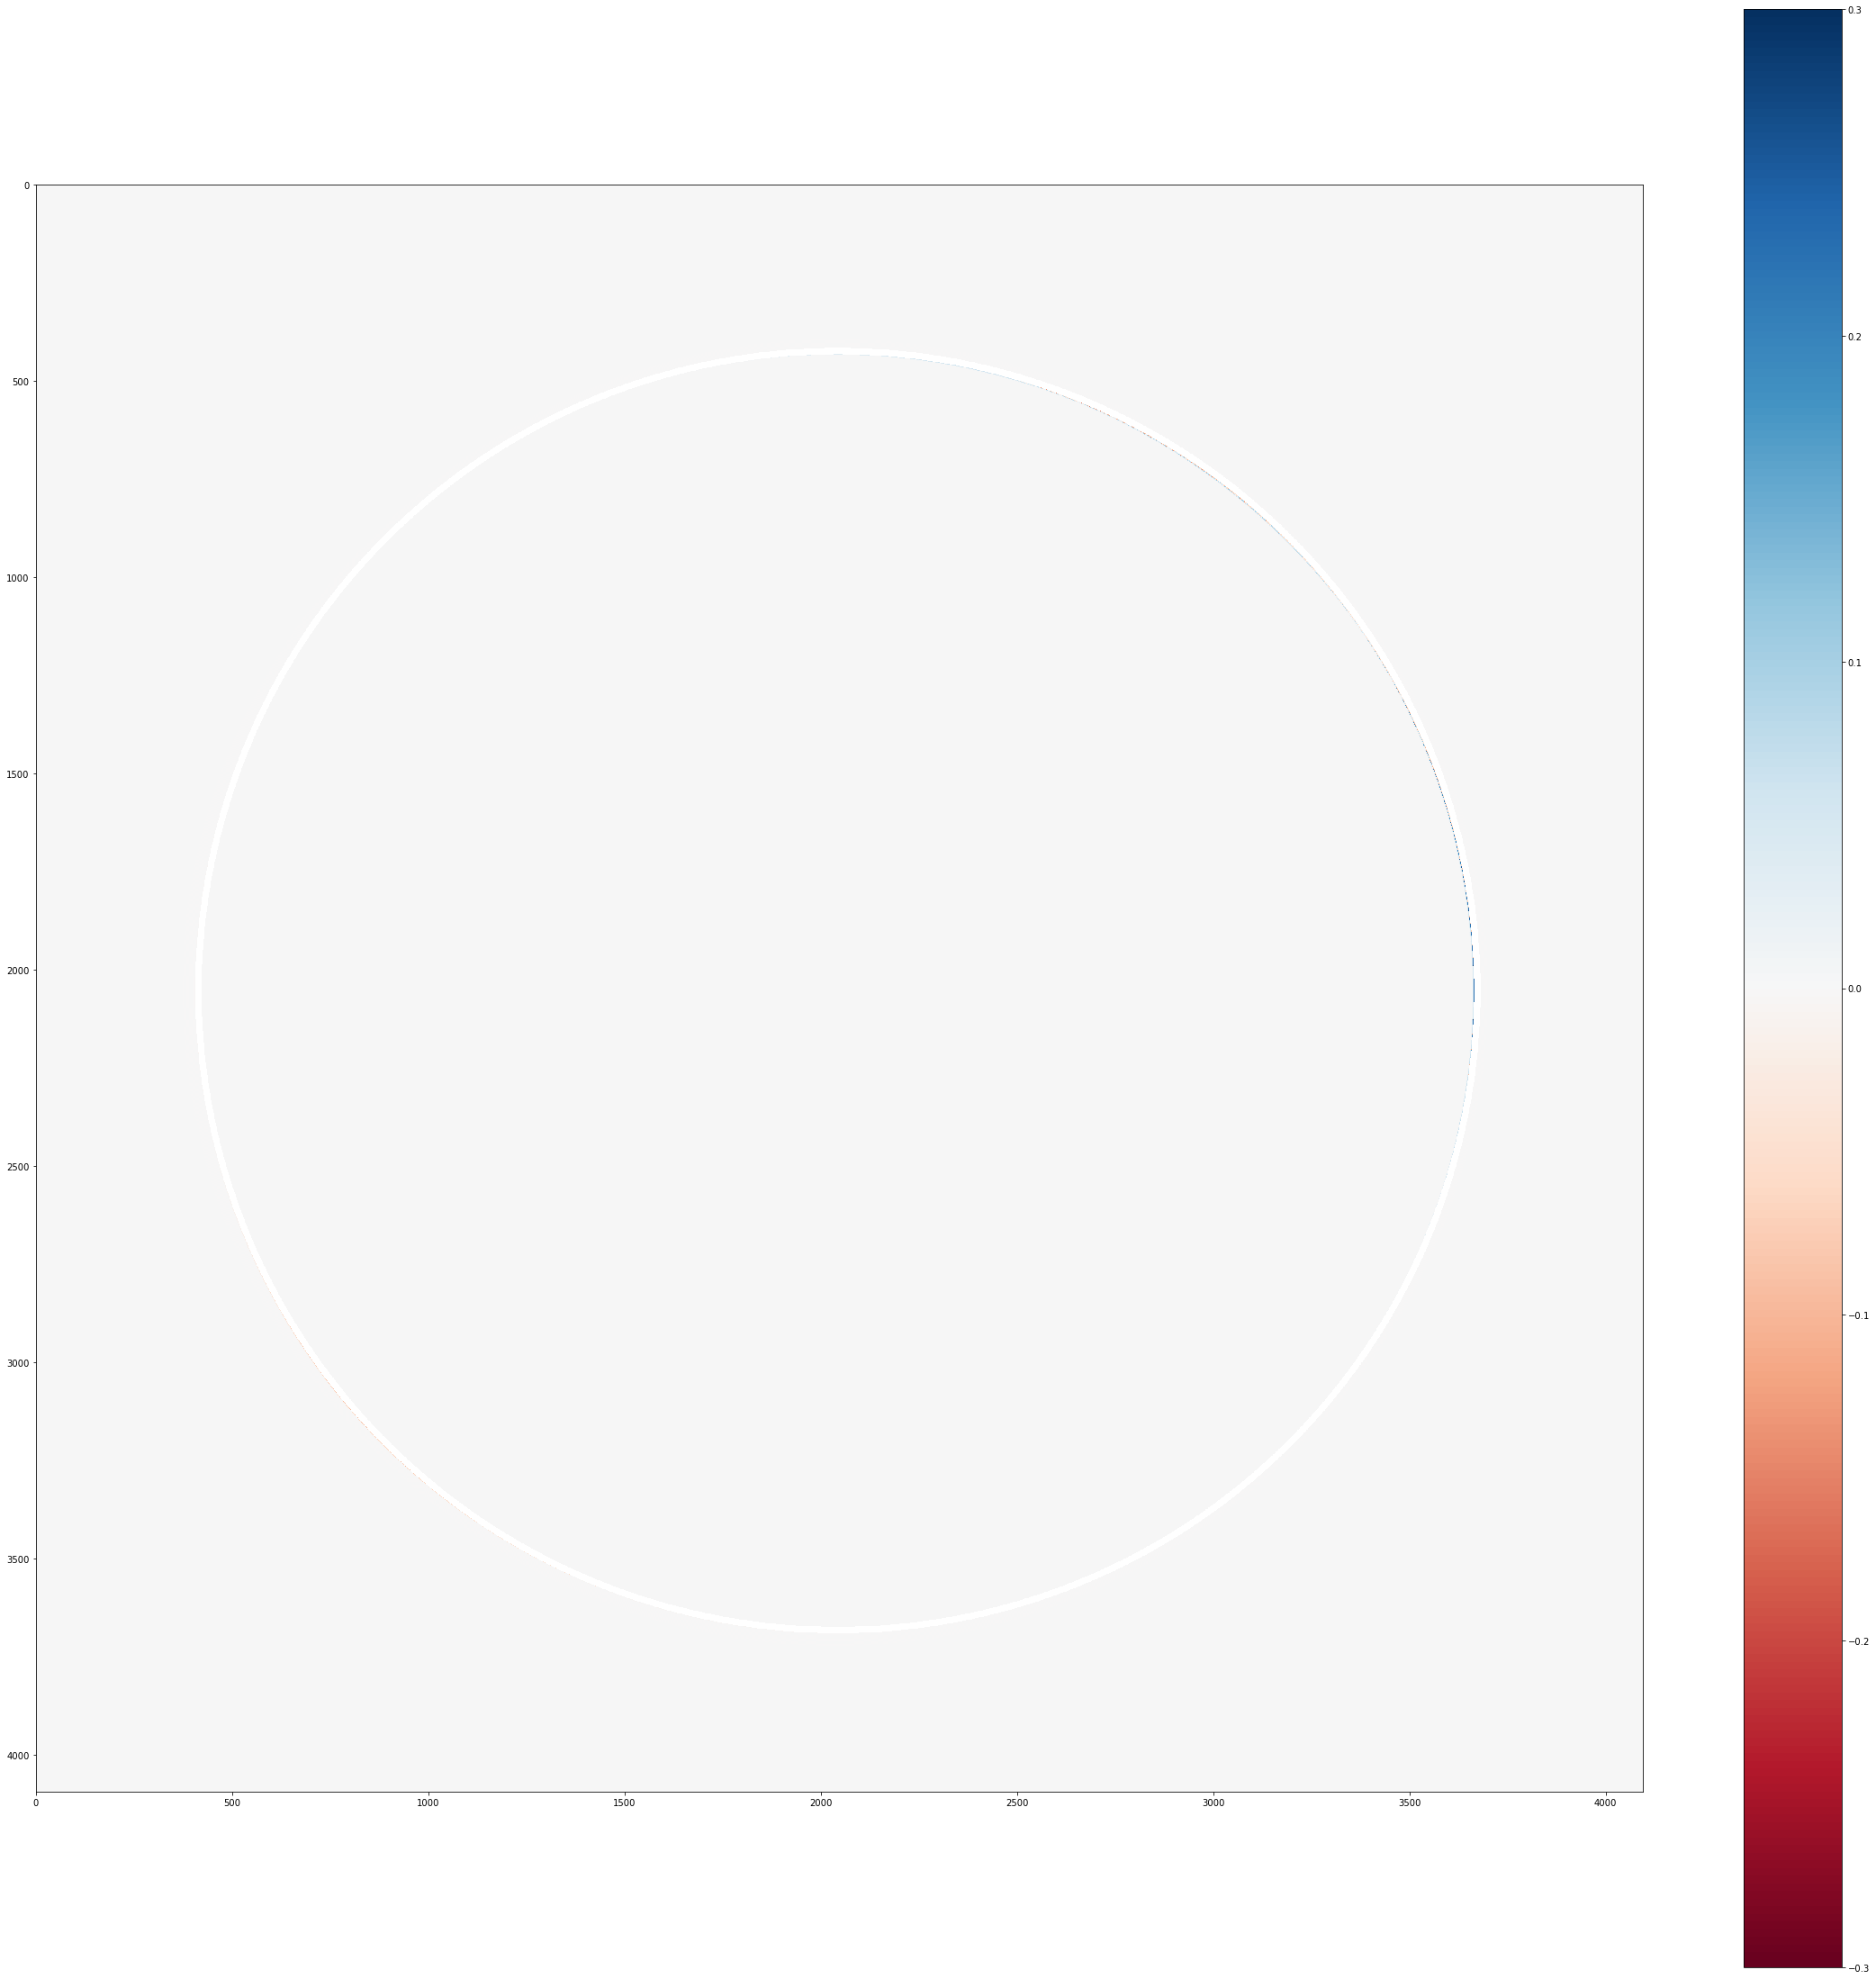

In [272]:
plt.figure(figsize=(40,40))
plt.imshow(m_prep_diff,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.colorbar()
plt.imshow(np.ma.masked_where(np.fabs((img_r / rsun_obs).value - 1) > 0.005,(img_r / rsun_obs).value),cmap='Greys',vmin=1,vmax=1)

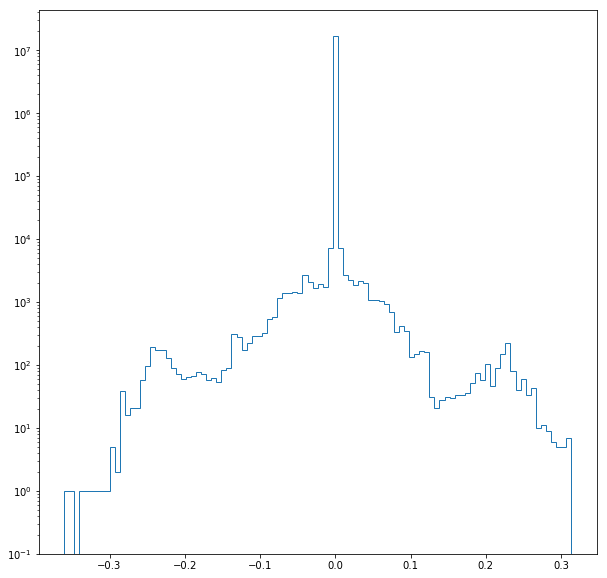

In [260]:
plt.figure(figsize=(10,10))
plt.hist(m_prep_diff.flatten(),log=True,histtype='step',bins=100);

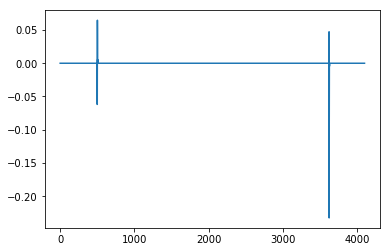

In [261]:
plt.plot(m_prep_diff[:,2500])